In [1]:
import simpy, random, logging
from queue_simulation import (
    ServiceOperation, SIMULATION_DURATION, SEED, CounsellorShift, Shifts, Roles,
    ExpectedArrivals, ArrivalRateType
)
from queue_simulation2 import (
    SocialWorkerShifts, DutyOfficerShifts, VolunteerShifts)

import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import itertools

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
sns.set();

In [4]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import font_manager

# modify matplotlib and seaborn settings
# to display Chinese 
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP'] 
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.labelweight'] = 'heavy'
plt.rcParams['font.weight'] = 'medium'

sns.set(font=['sans-serif'])
sns.set_style('dark',{'font.sans-serif':['Noto Serif CJK JP']})
sns.set_context('paper', font_scale=1.5)

In [5]:
folder = 'img' # image folder

# 1. plot counsellor shifts

In [6]:
meta = 'sim16_test'
br1 = 1
br2 = 1
NUM_SOCIAL_WORKERS = {
    Shifts.GRAVEYARD: br1+br2,
    Shifts.AM: 2,
    Shifts.PM: 2,
    Shifts.SPECIAL: 2
}

NUM_DUTY_OFFICERS = {
    Shifts.GRAVEYARD: 1,
    Shifts.AM: 1,
    Shifts.PM: 1,
    Shifts.SPECIAL: 0
}

NUM_VOLUNTEERS = {
    Shifts.GRAVEYARD: 1,
    Shifts.AM: 1,
    Shifts.PM: 1,
    Shifts.SPECIAL: 1
}

# br1 = 3
# br2 = 4
# NUM_SOCIAL_WORKERS = {
#     Shifts.GRAVEYARD: br1+br2,
#     Shifts.AM: 3,
#     Shifts.PM: 3,
#     Shifts.SPECIAL: 2
# }

# NUM_DUTY_OFFICERS = {
#     Shifts.GRAVEYARD: 1,
#     Shifts.AM: 1,
#     Shifts.PM: 1,
#     Shifts.SPECIAL: 0
# }

# NUM_VOLUNTEERS = {
#     Shifts.GRAVEYARD: 11,
#     Shifts.AM: 4,
#     Shifts.PM: 1,
#     Shifts.SPECIAL: 3
# }

In [7]:
# volunteer shifts
# from 8pm to 12am
# from 10:30am to 2:30 pm
# from 3pm to 7pm
# from 6pm to 10pm

volunteer_shifts = [
    CounsellorShift(Shifts.GRAVEYARD, Roles.VOLUNTEER, True, 1200, 1440, NUM_VOLUNTEERS[Shifts.GRAVEYARD]),
    CounsellorShift(Shifts.AM, Roles.VOLUNTEER, False, 630, 870, NUM_VOLUNTEERS[Shifts.AM]),
    CounsellorShift(Shifts.PM, Roles.VOLUNTEER, False, 900, 1140, NUM_VOLUNTEERS[Shifts.PM]),
    CounsellorShift(Shifts.SPECIAL, Roles.VOLUNTEER, False, 1080, 1320, NUM_VOLUNTEERS[Shifts.SPECIAL]),
]


# duty officer and social worker shifts
# from 9:30pm to 7:30am
# from 7:15am to 3:15 pm
# from 2pm to 10pm
# from 5pm to 1 am
    
duty_officer_shifts = [
    CounsellorShift(Shifts.GRAVEYARD, Roles.DUTY_OFFICER, True, 1290, 1890, NUM_DUTY_OFFICERS[Shifts.GRAVEYARD]),
    CounsellorShift(Shifts.AM, Roles.DUTY_OFFICER, False, 435, 915, NUM_DUTY_OFFICERS[Shifts.AM]),
    CounsellorShift(Shifts.PM, Roles.DUTY_OFFICER, False, 840, 1320, NUM_DUTY_OFFICERS[Shifts.PM]),
    CounsellorShift(Shifts.SPECIAL, Roles.DUTY_OFFICER, True, 1020, 1500, NUM_DUTY_OFFICERS[Shifts.SPECIAL]),
]
            

social_worker_shifts = [
    CounsellorShift(Shifts.GRAVEYARD, Roles.SOCIAL_WORKER, True, 1290, 1890, br1),
    CounsellorShift(Shifts.GRAVEYARD, Roles.SOCIAL_WORKER2, True, 1290, 1890, br2),
    CounsellorShift(Shifts.AM, Roles.SOCIAL_WORKER, False, 435, 915, NUM_SOCIAL_WORKERS[Shifts.AM]),
    CounsellorShift(Shifts.PM, Roles.SOCIAL_WORKER, False, 840, 1320, NUM_SOCIAL_WORKERS[Shifts.PM]),
    CounsellorShift(Shifts.SPECIAL, Roles.SOCIAL_WORKER, True, 1020, 1500, NUM_SOCIAL_WORKERS[Shifts.SPECIAL]),
]

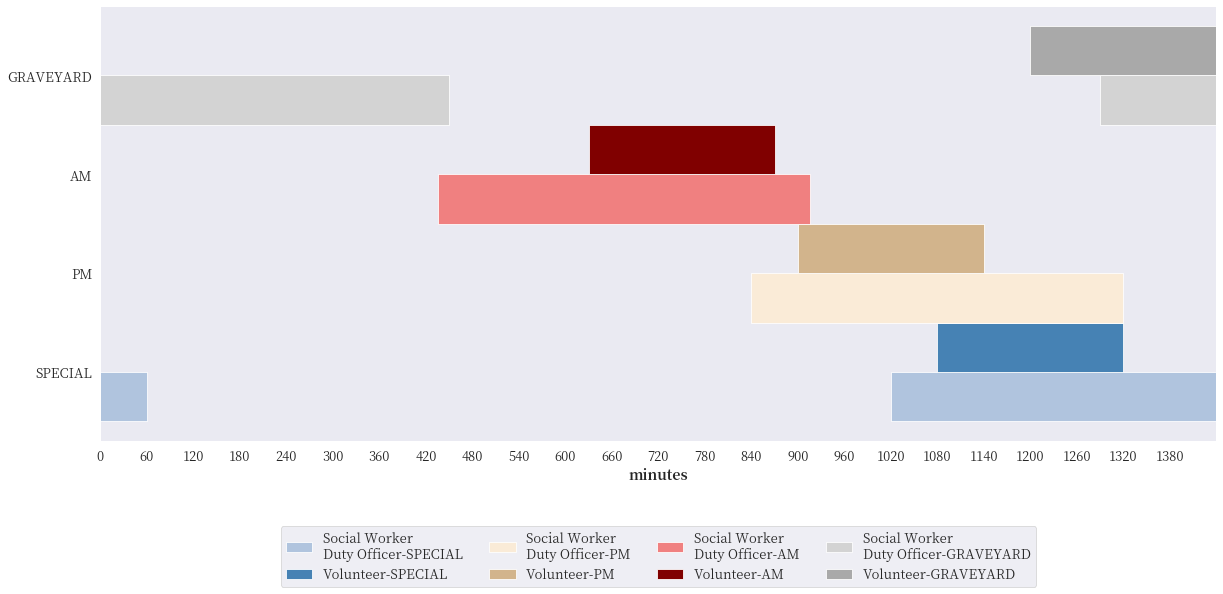

In [8]:
fig, ax = plt.subplots( figsize=(20, 8))
ax.set_xlim(0, 1440)


# special
ax.broken_barh([(SocialWorkerShifts.SPECIAL.start, 1440),
    (0, SocialWorkerShifts.SPECIAL.end%1440)],
    (1, 1), facecolors='lightsteelblue',
    label=f'Social Worker\nDuty Officer-{Shifts.SPECIAL.name}')
ax.broken_barh([(VolunteerShifts.SPECIAL.start,
    VolunteerShifts.PM.duration)],
    (2, 1), facecolors='steelblue',
    label=f'Volunteer-{Shifts.SPECIAL.name}')


# PM
ax.broken_barh([(SocialWorkerShifts.PM.start,
    SocialWorkerShifts.PM.duration)],
    (3, 1), facecolors='antiquewhite',
    label=f'Social Worker\nDuty Officer-{Shifts.PM.name}'
)
ax.broken_barh([(VolunteerShifts.PM.start,
    VolunteerShifts.PM.duration)],
    (4, 1), facecolors='tan',
    label=f'Volunteer-{Shifts.PM.name}'
)



# AM
ax.broken_barh([(SocialWorkerShifts.AM.start, 
    SocialWorkerShifts.AM.duration)],
    (5, 1), facecolors='lightcoral',
    label=f'Social Worker\nDuty Officer-{Shifts.AM.name}'
)
ax.broken_barh([(VolunteerShifts.AM.start, 
    VolunteerShifts.AM.duration)],
    (6, 1), facecolors='maroon',
    label=f'Volunteer-{Shifts.AM.name}'
)


# graveyard
ax.broken_barh([(SocialWorkerShifts.GRAVEYARD.start, 1440),
    (0, SocialWorkerShifts.GRAVEYARD.end%1440)],
    (7, 1), facecolors='lightgrey',
    label=f'Social Worker\nDuty Officer-{Shifts.GRAVEYARD.name}'              
)
ax.broken_barh([(VolunteerShifts.GRAVEYARD.start,
    VolunteerShifts.GRAVEYARD.end)],
    (8, 1), facecolors='darkgrey',
    label=f'Volunteer-{Shifts.GRAVEYARD.name}',
)


ax.set_xticks([x for x in range(0, 1440, 60)])
ax.set_xlabel('minutes')
ax.set_yticks([x for x in range(2, 9 , 2)])
ax.set_yticklabels([s.name for s in Shifts][::-1])

# fig.suptitle('Counsellor Shifts', fontweight='bold', fontsize=24)
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -.35), ncol=4)

fig.savefig(f'{folder}/shifts.png', dpi=300, bbox_inches='tight')

plt.show()

# 2. Queue Simulation (multi-process to speed up bootstrap)

In [9]:
import multiprocessing as mp
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from statsmodels.tsa.statespace.structural import UnobservedComponents

In [10]:
manager = mp.Manager()

In [11]:
queue_status = manager.list()
max_queue_length = manager.list()
num_users = manager.list()
num_users_accepted_TOS = manager.list()
num_users_rejected_TOS = manager.list()
num_users_served = manager.list()
num_users_served_g_regular = manager.list()
num_users_served_g_repeated = manager.list()
num_users_served_g_valid = manager.list()
num_users_reneged = manager.list()
# num_users_reneged_g_regular = manager.list()
# num_users_reneged_g_repeated = manager.list()
num_available_counsellor_processes = manager.list()
queue_time_stats = manager.list()
renege_time_stats = manager.list()
queue_time_stats_transfer = manager.list()
renege_time_stats_transfer = manager.list()
case_chat_time = manager.list()

In [12]:
# comment out line if not reproducing results
random.seed(728)
np.random.seed(728)

num_iterations = 1500 # this should be multiples of num_cores
num_cores = max(mp.cpu_count()-2, 2)

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1722: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])
/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1722: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


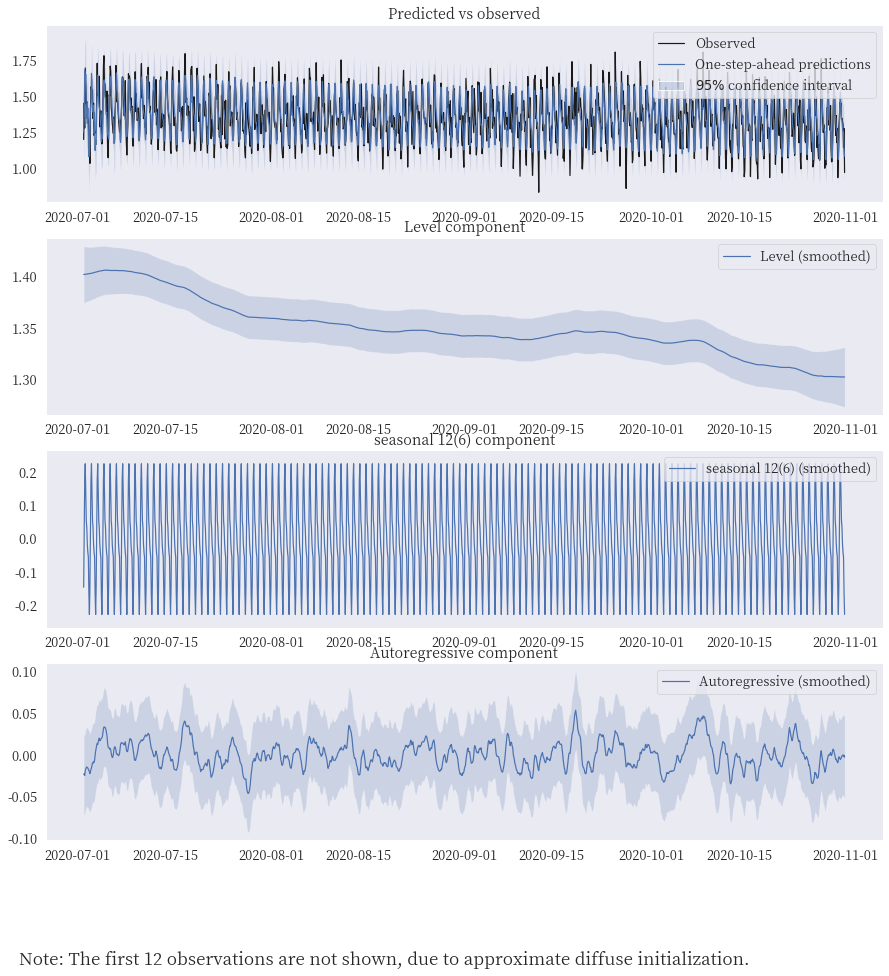

In [13]:
arrivals = ExpectedArrivals()
arrivals.fitted_ts.plot_components(figsize=(15, 15))
plt.show()

In [14]:
def run_simulation(
        queue_status,
        max_queue_length,
        num_users,
        num_users_accepted_TOS,
        num_users_rejected_TOS,
        num_users_served,
        num_users_served_g_regular,
        num_users_served_g_repeated,
        num_users_served_g_valid,
        num_users_reneged,
        num_available_counsellor_processes,
        queue_time_stats,
        renege_time_stats,
        queue_time_stats_transfer,
        renege_time_stats_transfer,
        case_chat_time):

    for i in tqdm(
        range(num_iterations//num_cores), 
        desc='OpenUp Queue Simulation'):

        try:
            # create environment
            env = simpy.Environment() 

            # set up service operation and run simulation until  
            S = ServiceOperation(
                env=env,
                volunteer_shifts=volunteer_shifts,
                duty_officer_shifts=duty_officer_shifts,
                social_worker_shifts=social_worker_shifts,
                arrivals=arrivals,
                arrival_rate_type=ArrivalRateType.MEAN,
                use_actual_interarrivals=False
            )
            env.run(until=SIMULATION_DURATION)


            num_users.append(S.num_users)   
            num_users_accepted_TOS.append(S.num_users_TOS_accepted)
            num_users_rejected_TOS.append(S.num_users_TOS_rejected)
            max_queue_length.append(S.user_queue_max_length)
            
            queue_status.append(pd.DataFrame(S.queue_status) )
            num_available_counsellor_processes.append(
                pd.DataFrame(S.num_available_counsellor_processes,
                             columns=['time', 'num_counsellor_processes_idle'])
            )
            
            num_users_served.append(S.served)
            num_users_served_g_regular.append(S.served_g_regular)
            num_users_served_g_repeated.append(S.served_g_repeated)
            num_users_served_g_valid.append(S.served_g_valid)
            num_users_reneged.append(S.reneged)
            
            queue_time_stats.append(pd.DataFrame(S.queue_time_stats) )
            renege_time_stats.append(pd.DataFrame(S.renege_time_stats) )
            
            queue_time_stats_transfer.append(pd.DataFrame(S.queue_time_stats_transfer) )
            renege_time_stats_transfer.append(pd.DataFrame(S.renege_time_stats_transfer) )
            
            case_chat_time.append(pd.DataFrame(S.case_chat_time,
                                            columns=['cumulative_chat_time']) )
            
        #     num_users_reneged_g_regular.append(S.reneged_g_regular)
        #     num_users_reneged_g_repeated.append(S.reneged_g_repeated)
        except ValueError:
            print(f'Negative delay at {i}.  Results are dropped.')

## divide up jobs to `num_cores`, and merge results when complete

In [15]:
jobs = [mp.Process(target=run_simulation, args=[
            queue_status,
            max_queue_length,
            num_users,
            num_users_accepted_TOS,
            num_users_rejected_TOS,
            num_users_served,
            num_users_served_g_regular,
            num_users_served_g_repeated,
            num_users_served_g_valid,
            num_users_reneged,
            num_available_counsellor_processes,
            queue_time_stats,
            renege_time_stats,
            queue_time_stats_transfer,
            renege_time_stats_transfer,
            case_chat_time
        ]) for i in range(num_cores)]        
    
for j in jobs:
    j.start()
    
    
for j in jobs:
    j.join()

OpenUp Queue Simulation: 100%|██████████| 250/250 [06:14<00:00,  1.50s/it]


## convert to pandas objects

In [16]:
num_users = pd.Series(np.array(num_users), name='number of users')
num_users_accepted_TOS = pd.Series(np.array(num_users_accepted_TOS), name='number of users accepting TOS')
num_users_rejected_TOS = pd.Series(np.array(num_users_rejected_TOS), name='number of users rejecting TOS')
num_users_served = pd.Series(np.array(num_users_served), name='number of users served')
num_users_served_g_regular = pd.Series(np.array(num_users_served_g_regular), name='number of users served')
num_users_served_g_repeated = pd.Series(np.array(num_users_served_g_repeated), name='number of repeated users served')
num_users_served_g_valid = pd.Series(np.array(num_users_served_g_valid), name='number of cases passing valid threshold')
num_users_reneged = pd.Series(np.array(num_users_reneged), name='number of users reneged')
# num_users_reneged_g_regular = pd.Series(num_users_reneged_g_regular, name='number of users reneged')
# num_users_reneged_g_repeated = pd.Series(num_users_reneged_g_repeated, name='number of repeated users reneged')
queue_status = pd.concat(queue_status)
max_queue_length = pd.Series(np.array(max_queue_length), name='max queue length')
queue_time_stats = pd.concat(queue_time_stats)
renege_time_stats = pd.concat(renege_time_stats)
num_available_counsellor_processes = pd.concat(num_available_counsellor_processes)
case_chat_time = pd.concat(case_chat_time)

In [17]:
# function to calculate classification confidence intervals
# parameter: stats - list of confidence intervals, which must be ordered
#            metadata - any string to annotate printout, can be None
# precondition - metadata must be a string or None, and stats must be a list
#                  The check is commented out for now as asserts should 
#               be done outside function
# returns: cutoff values at 2.5% and 95% percentiles
def calculate_confidence_intervals(stats, metadata=None, verbose=True):
    # if not isinstance(metadata, None) or \
    #     not isinstance(metadata, str) or \
    #     not isinstance(stats, list):
    #     return
        
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(stats, q_lower)
    upper_percentile = np.percentile(stats, q_upper)
    mean = np.mean(stats)
    
    if verbose:
        print('\n%s %d%% Confidence interval:' % (
            metadata, confidence_interval) )
        print('----------------------------')
        print('%.1f%% percentile: %.5f' % (q_lower, lower_percentile) )
        print('%.1f%% percentile: %.5f\n' % (q_upper, upper_percentile) )
        print('mean value: %.5f' % mean)
    return (lower_percentile, upper_percentile, mean)

In [18]:
def plot_distribution(series, filename):
    confidence_interval = .95 # 95 percent confidence level
    q_lower = .5 * (1 - confidence_interval)
    q_upper = confidence_interval + q_lower
        
    # convert to percentages
    q_lower = q_lower * 100
    q_upper = q_upper * 100
    confidence_interval = confidence_interval * 100
        
    #     print(q_lower, q_upper)
    lower_percentile = np.percentile(series, q_lower)
    upper_percentile = np.percentile(series, q_upper)
    mean = np.mean(series)
    
    
    fig, ax = plt.subplots(1, 1, figsize=(7, 5) )
    sns.distplot(series, ax=ax)
    ax.axvline(x=lower_percentile, linestyle='--' )
    ax.axvline(x=upper_percentile, linestyle='--' )
    ax.axvline(x=mean, linestyle=':', linewidth=2 )
    
    fig.savefig(f'{folder}/{filename}.png', dpi=300, bbox_inches='tight')

/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


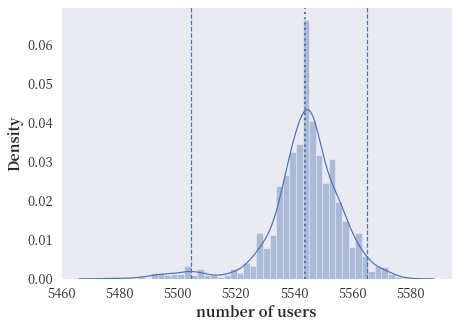

In [19]:
plot_distribution(num_users, 'num_users')

In [20]:
lower, upper, total_incoming = calculate_confidence_intervals(
    num_users.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 5504.47500
97.5% percentile: 5565.00000

mean value: 5543.53600


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


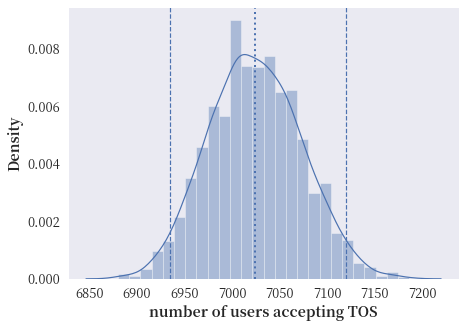

In [21]:
plot_distribution(num_users_accepted_TOS, 'num_users_accepting_TOS')

In [21]:
lower, upper, tos_acceptance = calculate_confidence_intervals(
    num_users_accepted_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 4075.00000
97.5% percentile: 4211.00000

mean value: 4145.14800


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


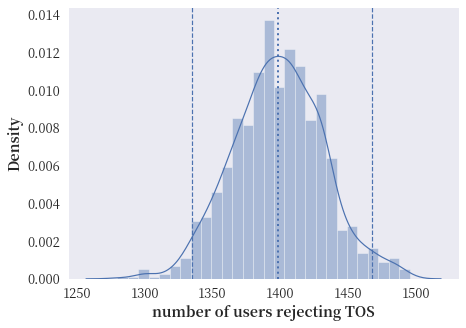

In [22]:
plot_distribution(num_users_rejected_TOS, 'num_users_rejecting_TOS')

In [23]:
lower, upper, tos_rejections = calculate_confidence_intervals(
    num_users_rejected_TOS.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 1335.00000
97.5% percentile: 1467.00000

mean value: 1398.38800


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


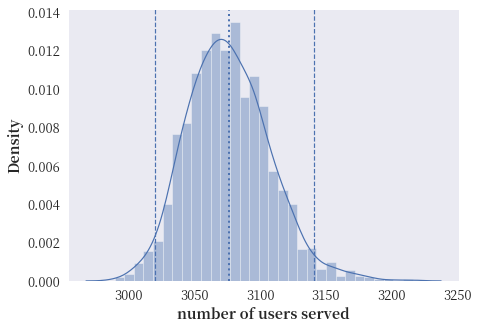

In [24]:
plot_distribution(num_users_served, 'num_users_served')

In [25]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 3020.00000
97.5% percentile: 3141.00000

mean value: 3075.80067


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


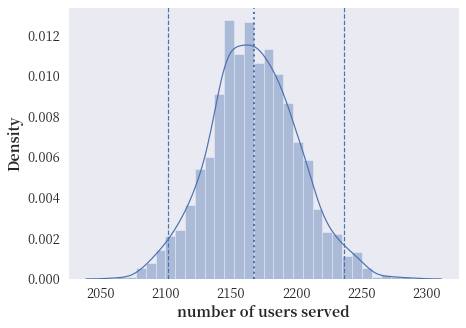

In [26]:
plot_distribution(num_users_served_g_regular, 'num_users_served_g_regular')

In [27]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_regular.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 2102.00000
97.5% percentile: 2236.52500

mean value: 2167.51267


/home/cathug/miniconda3/envs/csrp/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


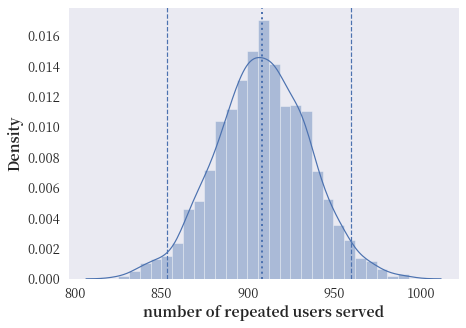

In [28]:
plot_distribution(num_users_served_g_repeated, 'num_users_served_g_repeated')

In [29]:
lower, upper, mean = calculate_confidence_intervals(
    num_users_served_g_repeated.sort_values().to_list() )


None 95% Confidence interval:
----------------------------
2.5% percentile: 853.00000
97.5% percentile: 959.52500

mean value: 908.28800


In [ ]:
plot_distribution(num_users_served_g_valid, 'num_users_served_g_repeated')

In [ ]:
lower, upper, users_served_above_threshold = calculate_confidence_intervals(
    num_users_served_g_valid.sort_values().to_list() )

In [ ]:
plot_distribution(num_users_reneged, 'num_users_reneged')

In [ ]:
lower, upper, users_reneged = calculate_confidence_intervals(
    num_users_reneged.sort_values().to_list() )

In [ ]:
# plot_distribution(num_users_reneged_g_regular, 'num_users_reneged_g_regular')

In [ ]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_regular.sort_values().to_list() )

In [ ]:
# plot_distribution(num_users_reneged_g_repeated, 'num_users_reneged_g_repeated')

In [ ]:
# lower, upper, mean = calculate_confidence_intervals(
#     num_users_reneged_g_repeated.sort_values().to_list() )

In [ ]:
max_queue_length_count = sns.countplot(x='max queue length', data=max_queue_length.to_frame())

max_queue_length_count.get_figure().savefig(f'{folder}/max_queue_length_count.png', dpi=300, bbox_inches='tight')

In [ ]:
queue_status['weekday'].replace({
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}, inplace=True)

In [ ]:
queue_status

In [ ]:
queue_status['total']=1

# chat time

In [ ]:
case_chat_time.describe().T

In [ ]:
# case_chat_time[case_chat_time['cumulative_chat_time']>0].describe().T

In [ ]:
# sns.histplot(case_chat_time['cumulative_chat_time'])

In [ ]:
# sns.kdeplot(case_chat_time['cumulative_chat_time'])

# queue length

In [ ]:
totals = queue_status.groupby(
    ['weekday', 'hour', 'queue_length']).sum()

In [ ]:
totals = totals.reset_index()

In [ ]:
totals

In [ ]:
totals = pd.pivot_table(totals, values='total', columns=['queue_length'],
              index=['hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
totals_percent = totals.div(totals.sum(axis=1), axis=0)#.round(2)

In [ ]:
totals_percent

In [ ]:
totals_percent['>=2'] = totals_percent[totals_percent.columns[totals_percent.columns >= 2]].sum(axis=1)

In [ ]:
totals_percent3 = totals_percent[[0, 1, '>=2']].copy()

In [ ]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR, 
    MAX_SIMULTANEOUS_CHATS)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )
palette = sns.color_palette("Set3")

# fig.suptitle(f'Conditional Queue Length Probabilities by hours of the day\n\n'
#     f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
#     f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
#     f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
#     fontsize=14, weight='heavy',
#     fontweight=1000, y=1.01)


    
totals_percent3.plot.bar(
        stacked=True,
        ax=ax,
        linewidth=.01,
        color=palette,
        rot=0
    )

ax.axhline(y=.85, linestyle='--', color='grey')
#     ax[i].set_xticklabels(labels=[f'{x[:3]}-{x[-1]} hr' 
#         if x[-2:] == '_0' else ''
#         for x in dataframe.index])

ax.set_xlabel('Hour')
ax.set_ylabel('Probability')
    
ax.legend(loc='lower center', 
    bbox_to_anchor=(0.5, -.6), 
    ncol=3,
    title='Queue Length'     
)
    
fig.tight_layout()

fig.savefig(f'{folder}/queue_length_prob_plot_{meta}.png', dpi=300, bbox_inches='tight')

# queue time

In [ ]:
# queue_plot = sns.catplot(col='weekday', y='hour', col_wrap=4,
#     col_order=['Sunday',
#         'Monday',
#         'Tuesday',
#         'Wednesday',
#         'Thursday',
#         'Friday',
#         'Saturday'],
#     data=queue_status, kind="count",
#     height=4, aspect=1);
# queue_plot.savefig(f'queue_blowup.png', dpi=300, bbox_inches='tight')

In [ ]:
queue_time_stats

In [ ]:
queue_time_stats['total']=1

In [ ]:
# # totals = 
# queue_time_stats.mean()

In [ ]:
queue_time_stats['queue_time_group'] = queue_time_stats['time_spent_in_queue'].apply(
    lambda x: 'direct' if x==0 else (
        '<5 minutes' if x < 5 and x>0 else (
        '5-10 minutes' if x >=5 and x<=10 else '>10 minutes'
        ) )
)

In [ ]:
queue_time_stats['queue_time_group']

In [ ]:
queue_time_stats = pd.pivot_table(queue_time_stats, values='total', columns=['queue_time_group'],
              index=['hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
queue_time_stats

In [ ]:
queue_time_stats_percent = (queue_time_stats.div(queue_time_stats.sum(axis=1), axis=0))#.round(2)

In [ ]:
averaged_queue_waiting_breakdown = queue_time_stats.sum()/num_iterations

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6) )
palette = sns.color_palette("Set3")

# fig.suptitle(f'Queue Time Probabilities by hours of the day\n\n'
#     f'{NUM_SOCIAL_WORKERS} Social Worker(s) × {MAX_SIMULTANEOUS_CHATS["SOCIAL_WORKER"]} sim chat(s) max.,\n'
#     f'{NUM_DUTY_OFFICERS} Duty Officer(s) × {MAX_SIMULTANEOUS_CHATS["DUTY_OFFICER"]} sim chat(s) max.,\n'
#     f'{NUM_VOLUNTEERS} Volunteer(s) × {MAX_SIMULTANEOUS_CHATS["VOLUNTEER"]} sim chat(s) max.',
#     fontsize=14, weight='heavy',
#     fontweight=1000, y=1.01)


queue_time_stats_percent[['direct', '<5 minutes', '5-10 minutes', '>10 minutes']].plot.bar(
        stacked=True,
        ax=ax,
        linewidth=.01,
        color=palette,
        rot=0
    )

ax.axhline(y=.85, linestyle='--', color='grey')

ax.set_xlabel('Hour')
ax.set_ylabel('Probability')
    
ax.legend(loc='lower center', 
                     bbox_to_anchor=(0.5, -.6), 
                     ncol=4,
                     title='queue time'
            )
    
fig.tight_layout()

fig.savefig(f'{folder}/queue_time_prob_plot_{meta}.png', dpi=300, bbox_inches='tight')

# determine hours counsellors are maxed out

In [ ]:
from queue_simulation import (
    MINUTES_PER_DAY, DAYS_IN_WEEK, MINUTES_PER_HOUR)

In [ ]:
num_available_counsellor_processes

In [ ]:
num_available_counsellor_processes['time_int'] = num_available_counsellor_processes['time'].astype(int)

In [ ]:
num_available_counsellor_processes['current_day_minutes'] = num_available_counsellor_processes['time_int'] % MINUTES_PER_DAY

In [ ]:
num_available_counsellor_processes['hour'] = (num_available_counsellor_processes['current_day_minutes'] / MINUTES_PER_HOUR).astype(int)

In [ ]:
num_available_counsellor_processes['total']=1

In [ ]:
num_available_counsellor_processes

In [ ]:
df2 = pd.pivot_table(
    num_available_counsellor_processes, values='total',
    columns=['num_counsellor_processes_idle'],
    index=['hour'], aggfunc=np.sum, fill_value=0)

In [ ]:
df2 = (((df2.T/df2.T.sum()).T)*100)#.round(2)

In [ ]:
# df2 = df2.reset_index(drop=False).drop(columns=['weekday'])
# selection = df2[df2['day_of_week']=='Monday'].copy()

In [ ]:
# df2.groupby('hour').mean()

In [ ]:
# selection.set_index(['day_of_week', 'hour']).to_excel(
#     'queue_output/num_idle_procs_SW_2434_DO_11_V_2423-45.xlsx')

In [ ]:
queue_time_stats

In [ ]:
renege_time_stats

In [ ]:
renege_time_stats['time_spent_in_queue'].describe()

In [ ]:
sns.kdeplot(renege_time_stats['time_spent_in_queue'])

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4) )
sns.histplot(renege_time_stats, x='hour',
             stat='probability', discrete=True, shrink=.8, ax=ax)

fig.savefig(f'{folder}/prob_reneged_{meta}.png',
            dpi=300, bbox_inches='tight')

In [ ]:
df2

In [ ]:
df2['>10'] = df2[df2.columns[df2.columns > 10]].T.sum()

In [ ]:
df2 = df2[[x for x in range(11)] + ['>10']].copy()

In [ ]:
df2 = df2.T

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10) )


sns.heatmap(df2[::-1], annot=True, ax=ax, annot_kws={"size": 12}, 
    cmap="coolwarm",
);
# fig.suptitle('Percentage of idle counsellor processes by hour',
#     fontsize=18, weight='heavy',
#     fontweight=1000)
# plt.subplots_adjust(bottom=0.2)
ax.set_ylabel('Probability that the given number\nof idle counsellor processes is idle')

fig.savefig(f'{folder}/num_idle_procs_{meta}.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
df2

# stage breakdown graph

In [ ]:
averaged_queue_waiting_breakdown

In [ ]:
from graphviz import Digraph

In [ ]:
num_total = int(np.round(total_incoming) )
num_tos_rejected = int(np.round(tos_rejections) )
num_tos_accepted = int(np.round(tos_acceptance) )
num_direct = int(np.round(averaged_queue_waiting_breakdown['direct']) )

num_enqueue_counsellor = int(np.round(averaged_queue_waiting_breakdown['5-10 minutes'] + \
    averaged_queue_waiting_breakdown['<5 minutes'] + \
    averaged_queue_waiting_breakdown['>10 minutes']) )
num_enqueue_dropout = int(np.round(users_reneged) )
num_enqueue = num_enqueue_counsellor + num_enqueue_dropout


num_cases_served_above_cutoff = int(np.round(users_served_above_threshold) )


In [ ]:
# create directed graph
width = '2'
fontname = 'TeX Gyre Heros'

g = Digraph(name='counsellor_dropout_highlight', format='png')


g.attr(rankdir='LR', size='10,8')
g.attr('node', **{'width':str(1.5), 'height':str(1.5)}, 
    shape='circle',
    fontname=fontname
)

g.attr('edge', fontname=fontname)




# root node
g.node('incoming', f'Incoming\n\nN={num_total}', penwidth=width)

# level 1
g.node('TOS_accepted', f'TOS\nAccepted\n\nN={num_tos_accepted}', penwidth=width)
g.node('TOS_rejected', f'TOS\nRejected\n\nN={num_tos_rejected}')

# level 2
g.node('direct', f'Handled\nDirectly\n\nN={num_direct}', penwidth=width)
g.node('enqueue', f'Enqueue\n\nN={num_enqueue}', penwidth=width)

# level 3
g.node('above_cutoff',
    f'>=7.5\nminutes\n\nN={num_cases_served_above_cutoff}', penwidth=width)


g.node('to_counsellor',
    f'To\nCounsellor\n\nN={num_enqueue_counsellor}', penwidth=width)
g.node('dropout_queue',
    f'Dropout\n(Queue)\n\nN={num_enqueue_dropout}', style='filled', penwidth=width)

# # level 4
# g.node('droupout_counsellor', 
#     f'Dropout\n(Counsellor)\n\nN={num_counsellor_dropout}', penwidth=width)
# g.node('valid_cases_chatbot', 
#     f'Valid Cases\n(Counsellor)\n\nN={num_counsellor_valid}')


# root edges
g.edge('incoming', 'TOS_accepted',
    label=f'p={(num_tos_accepted/num_total):.03f}')
g.edge('incoming', 'TOS_rejected',
    label=f'p={(num_tos_rejected/num_total):.03f}')

# level 1 edges
g.edge('TOS_accepted', 'direct',
    label=f'p={(num_direct/num_tos_accepted):.03f}', penwidth=width)
g.edge('TOS_accepted', 'enqueue',
    label=f'p={(num_enqueue/num_tos_accepted):.03f}', penwidth=width)

# level 2 edges
g.edge('direct', 'above_cutoff', penwidth=width)

g.edge('enqueue', 'to_counsellor',
    label=f'p={(num_enqueue_counsellor/num_enqueue):.03f}', penwidth=width)
g.edge('enqueue', 'dropout_queue',
    label=f'p={(num_enqueue_dropout/num_enqueue):.03f}', penwidth=width)

# # level 3 edges
g.edge('to_counsellor', 'above_cutoff', penwidth=width)

g

In [ ]:
g.render()

In [ ]:
g.render(f'img/incoming_case_breakdown_{meta}')